## Modeling Inspection of the Food Establishments in the City of Chicago

## Project Plan
 - Project Goal
 - Dataset and features
 - Exploratory data analysis (EDA) 
 - Patterns, insights, pecularities of data
 - Data preprocessing
 - Feature engineering and description
 - Cross-validation, hyperparameter tuning
 - Validation and learning curves
 - Prediction for hold-out and test samples
 - Model evaluation with metrics description
 - Conclusions


### Project Goal
The goal of this project is to model the vilolations/failures by the food establishments in the city of chicago. 

### Dataset and Features  
We used city of Chicago's Socrata Open Data (SODA) API to access food inspection data for 2018 and 2019. In addition to the food inspection data, we are using burglary/crime, 311 sanitation complaints, business license data as well.

## Exploratory Data Analysis 

In [3]:
#important libraries
%matplotlib inline
import sys
import os
import re
import time
import json
import warnings
warnings.filterwarnings('ignore')
sys.path.append('/Users/dipakrimal/work/')
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.set(rc={'figure.figsize':(12, 6),"font.size":20,"axes.titlesize":20,"axes.labelsize":20},style="darkgrid")
import matplotlib.dates as mdates
from datetime import datetime, date, time, timedelta
from sklearn.preprocessing import LabelEncoder
from geopy import distance
import geopy.distance
from sklearn.ensemble import GradientBoostingClassifier  #GBM algorithm
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, auc
from neighborhoods import gps_to_neighborhood
from sklearn.preprocessing import LabelEncoder

NEAR SOUTH SIDE


In [ ]:
food_data = pd.read_json('../data/raw/food-inspection.json',
                         convert_dates=['inspection_date'])
food_data.head(2)

In [ ]:
shape = food_data.shape
print(" So there are %d rows and %d columns in the data" %
      (shape[0], shape[1]))

In [ ]:
food_data.isna().sum()

In [ ]:
plt.figure(figsize=(12, 6))
#food_data.unstack.plot(['inspection_date'].hist(bins=16, use_index=True)
food_data['inspection_date'].hist(bins=29)
plt.title("Inspections by date")
plt.xlabel("Inspection Date")
plt.show()

Let us do some data clean up:

In [ ]:
food_data['event_date'] = food_data['inspection_date']
food_data.rename(columns={'license_': 'license'}, inplace=True)
food_data['inspection_date'] = food_data['inspection_date'].dt.date
food_data = food_data[np.isfinite(food_data['license'])]
food_data = food_data[(food_data['license'] > 0)
                      & (food_data['inspection_date'] != 0)]
food_data = food_data.drop(['location', 'zip', 'state', 'city'], axis=1)
food_data['latitude'].fillna(food_data['latitude'].mode()[0], inplace=True)
food_data['longitude'].fillna(food_data['longitude'].mode()[0], inplace=True)
food_data['aka_name'].fillna(food_data['dba_name'], inplace=True)
food_data['license'] = food_data['license'].astype('int')

In [ ]:
food_data.isna().sum()

In [ ]:
#what's in the data? 
food_data.info()

In [ ]:
all_neighborhoods = gps_to_neighborhood.get_all_neighborhoods()
food_data['neighborhood'] = food_data.apply(
    lambda x: gps_to_neighborhood.find_neighborhood(x['longitude'], x[
        'latitude'], all_neighborhoods),
    axis=1)

In [ ]:
food_data['neighborhood'].value_counts()

In [ ]:
#simple statistics
food_data.describe().T
#food_data.set_index('inspection_date')

In [ ]:
def count_violations(row):
    if row['violations'] is None:
        return [0]
    else:
        serious_violations_count = 0
        critical_violations_count = 0
        minor_violations_count = 0
        x = row['violations'].split('|')
        if row['inspection_date'] < pd.to_datetime('2018-07-01').date():
            codes = []
            for violation in x:
                match = int(re.search('[0-9]+', violation).group())
                #print(match)
                codes.append(match)
            for code in codes:
                if code < 15:
                    critical_violations_count += 1
                elif code > 15 and code < 30:
                    serious_violations_count += 1
                elif code > 30 and code < 45:
                    minor_violations_count += 1
            return [
                minor_violations_count, serious_violations_count,
                critical_violations_count
            ]
        else:
            for violation in x:
                if 'PRIORITY VIOLATION' in violation:
                    critical_violations_count += 1
                elif 'PRIORITY FOUNDATION VIOLATION' in violation:
                    serious_violations_count += 1
                elif 'CORE VIOLATION' in violation:
                    minor_violations_count += 1
            return [
                minor_violations_count, serious_violations_count,
                critical_violations_count
            ]

In [ ]:
food_data['violations_list'] = food_data.apply(lambda x: count_violations(x),
                                               axis=1)
food_data['minor_violations'] = food_data['violations_list'].apply(
    lambda x: x[0])
food_data['serious_violations'] = food_data['violations_list'].apply(
    lambda x: x[1] if len(x) > 1 else 0)
food_data['critical_violations'] = food_data['violations_list'].apply(
    lambda x: x[2] if len(x) > 1 else 0)
food_data['CriticalFound'] = food_data['critical_violations'].apply(
    lambda x: 1 if x > 0 else 0)

In [ ]:
plt.figure(figsize=(12, 6))
food_data[food_data['CriticalFound'] == 0]['event_date'].hist(
    bins=29, label="No Critical Violations")
food_data[food_data['CriticalFound'] == 1]['event_date'].hist(
    bins=29, label="Found Critical Violations")
plt.xlabel("Inspection Date")
plt.legend(loc='best')
plt.show()

In [ ]:
food_data.head()

Let's drop some redundant and unnecessary columns from the dataframe and also clean up column_names.

In [ ]:
food_data = food_data.drop(['violations_list', 'violations'], axis=1)

In [ ]:
food_data[food_data['license'] == 2]

In [ ]:
food_data.isna().sum()

#### Let's see the frequency of these inspections. 

In [ ]:
per_day = pd.DataFrame()
per_day = food_data[['inspection_date', 'inspection_id']]
per_day = per_day.set_index(pd.to_datetime(per_day['inspection_date']))
per_day = per_day.resample('W').count()
plt.rcParams['figure.figsize'] = 12, 5
fig, ax = plt.subplots()
fig.autofmt_xdate()
#ax.xaxis.set_minor_locator(locator)
ax.xaxis.set_major_locator(mdates.MonthLocator())
#ax.xaxis.set_minor_locator(mdates.DayLocator())
monthFmt = mdates.DateFormatter('%Y-%b')
ax.xaxis.set_major_formatter(monthFmt)

plt.plot(per_day.index, per_day, 'b-')
plt.xlabel('Inspection Date')
plt.ylabel('Number of Inspections')
plt.title('Weekly Inspections')
plt.show()

In [ ]:
print("%s unique facilites were inspected during the period" %
      food_data['license'].nunique())

## Let's look at the results of these inspection more closely: 
A facility can either pass, pass with conditions or fail. Following is an excerpt from the dataset documentation page:

"Establishments receiving a ‘pass’ were found to have no critical or serious violations (violation number 1-14 and 15-29, respectively). Establishments receiving a ‘pass with conditions’ were found to have critical or serious violations, but these were corrected during the inspection. Establishments receiving a ‘fail’ were found to have critical or serious violations that were not correctable during the inspection. An establishment receiving a ‘fail’ does not necessarily mean the establishment’s licensed is suspended. Establishments found to be out of business or not located are indicated as such".

In [ ]:
food_data['results'].value_counts()

In [ ]:
ax = sns.countplot(x="results", data=food_data)
plt.title("Result of Inspections")
plt.show()

### Let's convert results in to categorical variable first and the we will filter out non-relevant categories like 'Out of Business', 'Not Ready' and 'No Entry' facilities. 

In [ ]:
results_conv = {
    "results": {
        "Fail": 0,
        "Pass": 1,
        "Pass w/ Conditions": 1,
        "Out of Business": 2,
        "No Entry": 3,
        "Not Ready": 4,
        'Business Not Located': 5
    }
}
food_data.replace(results_conv, inplace=True)
print(food_data.results.dtype)

In [ ]:
food_data = food_data[food_data['results'] < 2]

In [ ]:
ax = sns.countplot(x="CriticalFound", data=food_data)
plt.title("Result of Inspections")
plt.show()

In [ ]:
# how about non_critical_violations ?
ax = sns.countplot(x="serious_violations", hue='CriticalFound', data=food_data)
plt.title("Distribution of Serious Violations")
plt.show()

In [ ]:
# how about non_critical_violations ?
ax = sns.countplot(x="minor_violations", hue='CriticalFound', data=food_data)
plt.title("Distribution of Minor Violations")
plt.show()

###  Inspection type: 
According to the dataset description, an inspection can be of the following types:

1) Canvass : The most common type of inspection performed at a frequency relative to the risk of the establishment

2) Consultation: when the inspection is done at the request of the owner prior to the opening of the establishment

3) Complaint: when the inspection is done in response to a complaint against the establishment

4) license : when the inspection is done as a requirement for the establishment to receive its license to operate

5) suspect food poisoning : when the inspection is done in response to one or more persons claiming to have gotten ill as a result of eating at the establishment (a specific type of complaint based inspection)

6) Task-force inspection: when an inspection of a bar or tavern is done.

7) Re-inspections:  Occurs for most types of these inspections and are indicated as such.

In [ ]:
food_data['inspection_type'].value_counts()

#### A picture speaks thousands numbers, right ? Let's look at these numbers as count plots. 

In [ ]:
plt.figure(figsize=(10, 6))
ax = sns.countplot(y="inspection_type", data=food_data)
plt.title("Result of Inspections")
plt.show()

#### Since our goal is here to model the failure in random canvas, we are going to focus on canvass inspections only. 

In [ ]:
food_data = food_data[food_data['inspection_type'] == 'Canvass']

In [ ]:
#food_data = food_data[(food_data['results']== 1) | (food_data['results']== 2) ]

In [ ]:
print(
    "%d different types of food establishment facilities were inspected during the period and %d different types of inpsections were conducted during the period."
    % (food_data['facility_type'].nunique(),
       food_data['inspection_type'].nunique()))

In [ ]:
food_data['facility_type'].value_counts()[0:10]

In [ ]:
# Setting anything other than Restaurants, Grocery store and School to other types
ftype = lambda x: "Other" if x not in [
    'Restaurant', 'Grocery Store', 'School'
] else x
plt.figure(figsize=(13, 13))
food_data['facility_type'] = food_data['facility_type'].map(ftype)
ax = sns.countplot(y="facility_type", data=food_data)
plt.title("Types of Facilities Inspected")
plt.show()

In [ ]:
food_data = food_data[(food_data['facility_type'] == 'Restaurant') |
                      (food_data['facility_type'] == 'Grocery Store')]

In [ ]:
food_data.sort_values(by='inspection_date', inplace=True)
#food_data.set_index(['date'])
#food_data = food_data.set_index(['inspection_date'])
#food_data = food_data.sort_values(by=['inspection_date'], ascending=False)
#food_data['time_since_last_inspection'] = food_data.groupby(['license'])['inspection_date'].shift(-1)
#food_data[food_data['license'] == 28176]

### Risk categories: 
    
Each establishment is categorized as to its risk of adversely affecting the public’s health:

 1: High

 2: Medium 

 3: Low 

The frequency of inspection is tied to this risk, with risk 1 establishments inspected most frequently and risk 3 least frequently.

In [ ]:
food_data['risk'].value_counts()[0:10]

In [ ]:
plt.figure(figsize=(12, 8))
ax = sns.countplot(y="risk", data=food_data)
plt.title("Risk")
plt.show()

## Label Encoding categorical variables:

There are couple different ways of label encoding categorical variables.

1) First method is to replace those variables with a dictionary involving key and value pairs of the variables to be encoded. 

2) Another method is to change their type as categorical variable. Let's convert inspection_type for example as as categorical variable. 

In [ ]:
#food_data["inspection_type"] = food_data["inspection_type"].astype('category')
food_data["facility_type"] = food_data["facility_type"].astype('category')
food_data["risk"] = food_data["risk"].astype('category')
#food_data["inspection_type_cat"] = food_data["inspection_type"].cat.codes
food_data["facility_type_cat"] = food_data["facility_type"].cat.codes
food_data["risk_type_cat"] = food_data["risk"].cat.codes

In [ ]:
food_data.isna().sum()

I want to see look these establishments in the map. For plotting, let's divide them into pass and fail data frames.

In [ ]:
pass_inspection = food_data[(food_data['results'] == 1)]
fail_inspection = food_data[food_data['results'] == 0]

## Let's utilize plotly and mapbox to display these restaurants in a map:

In [ ]:
import plotly as py
import plotly.graph_objs as go
py.offline.init_notebook_mode()

py.tools.set_credentials_file(username='dipakrimal',
                              api_key='0d7jgOoPDZTZV2J0l5u4')
mapbox_access_token = os.getenv('MAPBOX_ACCESS_TOKEN')

data_pass = [
    go.Scattermapbox(lat=pass_inspection['latitude'],
                     lon=pass_inspection['longitude'],
                     mode='markers',
                     marker=go.scattermapbox.Marker(size=12,
                                                    color='rgb(50, 200, 55)',
                                                    opacity=0.7),
                     text=pass_inspection['dba_name'] + ' <br> Pass ',
                     hoverinfo='text'),
    go.Scattermapbox(lat=fail_inspection['latitude'],
                     lon=fail_inspection['longitude'],
                     mode='markers',
                     marker=go.scattermapbox.Marker(size=12,
                                                    color='rgb(255, 0, 0)',
                                                    opacity=0.7),
                     text=fail_inspection['dba_name'] + ' <br> Fail ',
                     hoverinfo='text')
]

layout = go.Layout(
    title="Chicago Food Insepections",
    width=600,
    height=800,
    showlegend=False,
    hovermode='closest',
    mapbox=go.layout.Mapbox(accesstoken=mapbox_access_token,
                            bearing=0,
                            center=go.layout.mapbox.Center(lat=41.9,
                                                           lon=-87.7),
                            pitch=10,
                            zoom=9,
                            style='outdoors'),
)

fig = go.Figure(data=data_pass, layout=layout)

py.offline.iplot(fig, filename='Chicago')

In [ ]:
print(food_data.shape)
print(food_data.head(5))

In [ ]:
#df = food_data.groupby(['license'])

In [ ]:
weather = pd.read_csv('../data/raw/weather.csv',
                      index_col='DATE',
                      parse_dates=['DATE'])
weather = weather[weather['STATION'] == "USW00094846"]
#weather.head()

In [ ]:
weather.shape

In [ ]:
weather['TMAX'].plot()
weather['TMAXAVG'] = weather['TMAX'].rolling(window=3, min_periods=1).mean()
#weather = weather.set_index('DATE')
weather['TMAXAVG'].plot()

In [ ]:
weather.shape

In [ ]:
food_data = pd.merge(left=food_data, right=weather, left_on='event_date', right_on='DATE')

In [ ]:
food_data.shape

In [ ]:
#food_data['date'] = food_data['inspection_date']
#food_data['bus_license'] = food_data['license']
#food_data = food_data.set_index(['date', 'license'])

## Burglary Data
Is there any connection with the crime and food inspection failures? May be ! For now, I am focusing on the burgalaries only. The burglary data is the chicago's crime data filtered for burgalaries only (in the same time window i.e. first 3 months of 2019). 

In [ ]:
burglary = pd.read_json('../data/raw/burglary.json', convert_dates=['date'])

In [ ]:
burglary.head()

In [ ]:
shape = burglary.shape
print(" There are %d rows and %d columns in the data" % (shape[0], shape[1]))
print(burglary.info())

In [ ]:
burglary.isna().sum()

In [ ]:
burglary['latitude'].fillna(burglary['latitude'].mode()[0], inplace=True)
burglary['longitude'].fillna(burglary['longitude'].mode()[0], inplace=True)

In [ ]:
#burglary.groupby('district')['case_number'].hist()

In [ ]:
#burglary.groupby('district')['ward'].count()

In [ ]:
ax = sns.countplot(x="ward", data=burglary)
plt.title("Burglaries by Ward")
plt.show()

####  This is just a placeholder to associate these wards on the map, not the correct map yet. I am trying to make a similar map to show burglary statistics. 

In [ ]:
import gmaps
APIKEY= os.getenv('GMAPAPIKEY')
gmaps.configure(api_key=APIKEY)

In [ ]:
def make_heatmap(locations, weights=None):
    fig = gmaps.figure()
    heatmap_layer = gmaps.heatmap_layer(locations)
    #heatmap_layer.max_intensity = 100
    heatmap_layer.point_radius = 8
    fig.add_layer(heatmap_layer)
    return fig
    

In [ ]:
locations = zip(burglary['latitude'], burglary['longitude'])
fig = make_heatmap(locations)
fig

In [ ]:
burglary_per_day = pd.DataFrame()
burglary_per_day = burglary[['date', 'case_number']]
burglary_per_day = burglary_per_day.set_index(
    pd.to_datetime(burglary_per_day['date']))
burglary_per_day = burglary_per_day.resample('D').count()
plt.rcParams['figure.figsize'] = 12, 5
fig, ax = plt.subplots()
fig.autofmt_xdate()
#
#ax.xaxis.set_major_locator(mdates.MonthLocator())
#ax.xaxis.set_minor_locator(mdates.DayLocator())
monthFmt = mdates.DateFormatter('%Y-%b')
ax.xaxis.set_major_formatter(monthFmt)

plt.plot(burglary_per_day.index, burglary_per_day, 'r-')
plt.xlabel('Date')
plt.ylabel('Number of Cases Reported')
plt.title('Burglaries Reported')
plt.show()

In [ ]:
'''
import plotly.plotly as py
import plotly.figure_factory as ff
import numpy as np
import pandas as pd

aggs = ["count"]
agg = []
agg_func = []
for i in range(0, len(aggs)):
    agg = dict(
        args=['transforms[0].aggregations[0].func', aggs[i]],
        label=aggs[i],
        method='restyle'
    )
    agg_func.append(agg)


colorscale = [
    'rgb(193, 193, 193)',
    'rgb(239,239,239)',
    'rgb(195, 196, 222)',
    'rgb(144,148,194)',
    'rgb(101,104,168)',
    'rgb(65, 53, 132)'
]

fig = ff.create_choropleth(
    fips=fips, values=values, scope=['IL'],
    binning_endpoints=[14348, 63983, 134827, 426762, 2081313], colorscale=colorscale,
    county_outline={'color': 'rgb(255,255,255)', 'width': 0.5}, round_legend_values=True,
    legend_title='Crimes by Ward', title='Chicago IL'
)
py.iplot(fig, filename='choropleth_crimes_by_ward_chicago')
'''

In [ ]:
burglary['event_date'] = burglary['date']
burglary = burglary.set_index('event_date')
#burglary.sort_values(by='date', inplace=True)
burglary.head()

In [ ]:
burglary = burglary[['date', 'latitude', 'longitude']]


## Business License
Data from business licenses. This will help us looking into licensing situation of the business whether there is tobaco/alcohol liscences or how that is related to the inspection failure. or may help answer if the businesses are more cleaner when they are close to duedate for license renewal?  

In [ ]:
business = pd.read_json('../data/raw/business-license.json',
                        convert_dates=['license_start_date'])
business.head(2)
business.info()
date_window = pd.to_datetime('07/01/2016')
business = business[business['license_start_date'] > date_window]
business.to_csv("../data/processed/business_license_start_gt_2016-07-01.csv")

In [ ]:
date_cols = [
    'application_created_date', 'license_status_change_date', 'payment_date',
    'license_start_date', 'expiration_date', 'date_issued'
]
business = pd.read_csv(
    '../data/processed/business_license_start_gt_2016-07-01.csv',
    parse_dates=date_cols)

In [ ]:
ax = sns.countplot(x="application_type", data=business)
plt.title("Application Types")
plt.show()

APPLICATION TYPE: ‘ISSUE’ is the record associated with the initial license application. ‘RENEW’ is a subsequent renewal record. All renewal records are created with a term start date and term expiration date. ‘C_LOC’ is a change of location record. It means the business moved. ‘C_CAPA’ is a change of capacity record. Only a few license types may file this type of application. ‘C_EXPA’ only applies to businesses that have liquor licenses. It means the business location expanded.


LICENSE STATUS: ‘AAI’ means the license was issued. ‘AAC’ means the license was cancelled during its term.‘REV’means the license was revoked. ‘REA’means the license revocation has been appealed.

LICENSE STATUS CHANGE DATE: This date corresponds to the date a license was cancelled (AAC), revoked (REV) or appealed (REA).

In [ ]:
print(business.info())

In [ ]:
columns_to_take = [
    'license_description', 'id', 'business_activity_id', 'license_code',
    'license_number', 'conditional_approval', 'application_type',
    'expiration_date', 'license_start_date',
    'application_requirements_complete', 'conditional_approval',
    'business_activity', 'date_issued', 'license_status_change_date'
]
business = business[columns_to_take]
#column_dict = {}
#for column in columns_to_take:
#    column_dict[column] = column.lower().replace(' ', '_')
#business.rename(columns= column_dict, inplace=True)

business['license_number'] = business['license_number'].astype(int)
cond_approval = {"conditional_approval": {"N": 0, "Y": 1}}
business.replace(cond_approval, inplace=True)

In [ ]:
#inspected_matched_license = business[business.application_type=="ISSUE"]
#inspected_matched_license = inspected_matched_license[(inspected_matched_license['license_start_date']-pd.Timedelta(365)) < inspected_matched_license['expiration_date']]
#inspected_matched_license = inspected_matched_license.loc[:,~inspected_matched_license.columns.duplicated()]

In [ ]:
#inspected_matched_license.shape

In [ ]:
food_data.shape

In [ ]:
food_business_match = pd.merge(left=food_data,
                               right=business,
                               left_on='license',
                               right_on='license_number')
food_business_match.sort_values('inspection_date', inplace=True)

In [ ]:
food_business_match.shape

In [ ]:
food_business_match.head()

In [ ]:
food_business_match['HasTobaccoLicense'] = food_business_match[
    'license_description'].apply(lambda x: 1 if 'Tobacco' in x else 0)
food_business_match['HasAlcoholLicense'] = food_business_match[
    'license_description'].apply(
        lambda x: 1
        if 'Consumption on Premises - Incidental Activity' in x else 0)

In [ ]:
ax = sns.countplot(x="HasAlcoholLicense", data=food_business_match)
plt.title("Result")
plt.show()

In [ ]:
ax = sns.countplot(x="HasTobaccoLicense", data=food_business_match)
plt.title("Result")
plt.show()

In [ ]:
#food_business['HasTobaccoLicense'] = food_business.apply(lambda x : 1 if (x['license_code'] == 1780) or (x['license_code'] == 1787) else 0, axis=1)
#food_business['HasAlcoholLicense'] = food_business.apply(lambda x : 1 if (x['license_code'] == 1481) | (x['license_code'] == 1475) | (x['license_code'] == 1474) | (x['license_code'] == 1470) else 0 , axis = 1)

In [ ]:
#food_business.business_activity_id.value_counts()

Now I want to merge the inspection and business data frames. we can do inner join on license number from inspection data and License ID from business data.

In [ ]:
food_business = food_data.copy(deep=True)

In [ ]:
#food_business = food_business[food_business['inspection_date'] > pd.to_datetime('2018-07-01')]

## Garbage and Sanitation From (311 complaints)
Is there trash/garbage/sanitation/rodents etc complaints in the neighborhood or how that affects the outcome of the inspection. 

In [ ]:
garbage_prior_july18 = pd.read_json(
    '../data/raw/garbagedata_prior_to_july2018.json',
    convert_dates=['completion_date', 'creation_date'])
sanitation_prior_july18 = pd.read_json(
    '../data/raw/sanitationdata_prior_to_july2018.json',
    convert_dates=['completion_date', 'creation_date'])
rodent_prior_july18 = pd.read_json(
    '../data/raw/rodentdata_prior_to_july2018.json',
    convert_dates=['completion_date', 'creation_date'])

In [ ]:
service_prior_july18 = pd.concat(
    [garbage_prior_july18, sanitation_prior_july18, rodent_prior_july18],
    ignore_index=True)

In [ ]:
service_prior_july18.info()

In [ ]:
service_prior_july18 = service_prior_july18[[
    'creation_date', 'latitude', 'longitude', 'completion_date',
    'type_of_service_request'
]]
service_prior_july18.sort_values('creation_date', inplace=True)
service_prior_july18.rename(columns={
    'creation_date': 'created_date',
    'completion_date': 'closed_date',
    'type_of_service_request': 'sr_type'
},
                            inplace=True)

In [ ]:
service_prior_july18.head()

In [ ]:
service_data = pd.read_json(
    '../data/raw/servicedata.json',
    convert_dates=['closed_date', 'created_date', 'last_modified_date'])
service_data.head(3)

In [ ]:
service_data['sr_type'].value_counts()

In [ ]:
service_data['sr_type'].value_counts()

In [ ]:
service_data = service_data[service_data['sr_short_code'] != 'CHECKFOR']
service_data = service_data[[
    'created_date', 'latitude', 'longitude', 'closed_date', 'sr_type',
    'duplicate'
]]
service_data = pd.concat([service_data, service_prior_july18],
                         ignore_index=True)
sr_type_map = {
    "sr_type": {
        "Garbage Cart Black Maintenance/Replacement":
        "Garbage Cart Maintenance"
    }
}
service_data.replace(sr_type_map, inplace=True)
shape = service_data.shape
print(" So there are %d rows and %d columns in the data" %
      (shape[0], shape[1]))
#service_data['created_date'] = service_data['created_date'].dt.date

In [ ]:
print(service_data.info())

I now want to count number of these incidents around the business and within some prespecified time. We can optimize the distance and the time windows but for the first pass study, I am just foucsing on within 5 miles radii and the 7 days before the inspection date. 

In [ ]:
print("Latitude NA values = %s" % service_data.latitude.isna().sum())
print("Longitude NA values = %s" % service_data.longitude.isna().sum())

In [ ]:
service_data['latitude'].fillna(service_data['latitude'].mode()[0],
                                inplace=True)
service_data['longitude'].fillna(service_data['longitude'].mode()[0],
                                 inplace=True)
service_data = service_data[service_data['duplicate'] != True]
print(service_data.sr_type.value_counts())

In [ ]:
service_data.head()

In [ ]:
ax = sns.countplot(x='sr_type', data=service_data)
plt.title("Type of Service Request")
plt.show()

In [ ]:
service_data["sr_type"] = service_data["sr_type"].astype('category').cat.codes
service_data['created_date'].hist(bins = 32)

In [ ]:
service_data.sort_values(by='created_date', inplace=True)
service_data = service_data[['created_date','latitude', 'longitude']]

In [ ]:
from pandarallel import pandarallel
pandarallel.initialize()


def get_distance(a_lat, a_lng, b_lat, b_lng):
    R = 3956  # earth radius in miles
    a_lat = np.radians(a_lat)
    a_lng = np.radians(a_lng)
    b_lat = np.radians(b_lat)
    b_lng = np.radians(b_lng)
    d_lat = b_lat - a_lat
    d_lng = b_lng - a_lng

    d_lat_sq = np.sin(d_lat / 2)**2
    d_lng_sq = np.sin(d_lng / 2)**2

    a = d_lat_sq + np.cos(a_lat) * np.cos(b_lat) * d_lng_sq
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

    return R * c  # returns distance between a and b in mile


def count_burglaries(row):
    df = burglary.copy(deep=True)
    time_window = 30
    distance_window = 1
    df = df[(df['date'] >
             (row['inspection_date'] - pd.Timedelta(days=time_window)))
            & (df['date'] < (row['inspection_date']))]
    #df['d_time'] = (row['inspection_date'] - df['date']).dt.days
    #df = df[(df['d_time'] < 0) & (df['d_time'] >= -time_window)]
    df['distance'] = get_distance(row['latitude'], row['longitude'],
                                  df['latitude'].values,
                                  df['longitude'].values)
    dfNew = df[df['distance'] < distance_window]
    return dfNew.shape[0]


def count_sanitation_complaints(row):
    df = service_data.copy(deep=True)
    time_window = 30
    distance_window = 1
    #df['d_time'] = (row['inspection_date'] - df['created_date']).dt.days
    #df = df[(df['d_time'] < 0) & (df['d_time'] >= -time_window)]
    df = df[(df['created_date'] >
             (row['inspection_date'] - pd.Timedelta(days=time_window)))
            & (df['created_date'] < (row['inspection_date']))]
    df['distance'] = get_distance(row['latitude'], row['longitude'],
                                  df['latitude'].values,
                                  df['longitude'].values)
    dfNew = df[df['distance'] < distance_window]

    return dfNew.shape[0]
    #complaints = dfNew['sr_short_code'].value_counts()
    #comp_dict = {"sewer": complaints[0] , "sanitation": complaints[1], "rodent": complaints[2], "garbage": complaints[3]}
    #return comp_dict

In [ ]:
%timeit food_business['burglaries_last_month'] = food_business.parallel_apply(count_burglaries, axis=1)

In [ ]:
%timeit food_business['service_complains_last_month'] = food_business.parallel_apply(count_sanitation_complaints, axis=1)

In [ ]:
food_business.isna().sum()

In [ ]:
food_business = food_business[~food_business['neighborhood'].isna()]

In [ ]:
encoder = LabelEncoder()
food_business['neighborhood'] = encoder.fit_transform(
    food_business['neighborhood'])
mapping_dict = {}
le_name_mapping = dict(
    zip(encoder.classes_, encoder.transform(encoder.classes_)))
mapping_dict['neighborhood'] = le_name_mapping
#print(mapping_dict)

In [ ]:
pass_ins = food_business[food_business['CriticalFound'] == 1]
fail_ins = food_business[food_business['CriticalFound'] == 0]
#plt.xlim(-10, 500)
sns.distplot(pass_ins['service_complains_last_month'], hist=True, label='pass')
sns.distplot(fail_ins['service_complains_last_month'], hist=True, label='fail')
plt.show()

In [ ]:
sns.distplot(pass_ins['TMAXAVG'], hist=True, label='pass')
sns.distplot(fail_ins['TMAXAVG'], hist=True, label='fail')
plt.show()

In [ ]:
sns.distplot(pass_ins['burglaries_last_month'], bins=5, label='pass')
sns.distplot(fail_ins['burglaries_last_month'], bins=5, label='fail')
plt.show()

In [ ]:
food_business['neighborhood'].value_counts()

In [ ]:
# write t_test function
def t_test(a, b, alpha, alternative='two-sided'):
    from scipy import stats
    import scipy.stats as ss
    import pandas as pd
    import statsmodels.stats.weightstats as ws

    diff = a.mean() - b.mean()

    res = ss.ttest_ind(a, b, equal_var=False)

    means = ws.CompareMeans(ws.DescrStatsW(a), ws.DescrStatsW(b))
    confint = means.tconfint_diff(alpha=alpha,
                                  alternative=alternative,
                                  usevar='unequal')
    degfree = means.dof_satt()

    index = [
        'DegFreedom', 'Difference', 'Statistic', 'PValue', 'Low95CI',
        'High95CI'
    ]
    return pd.Series([degfree, diff, res[0], res[1], confint[0], confint[1]],
                     index=index)

In [ ]:
#sns.distplot(pass_ins['past_score'], bins=5, label = 'pass')
#sns.distplot(fail_ins['past_score'], bins=5, label = 'fail')
#plt.show()

#### I also want to use Yelp's rating and comments ( for some sort of sentiment analysis if possible) in my model. So let's see if that is feasible. To start with, I am focusing only on the restaurants (category) that failed in the inspection. Also note taht yelp caps 5000 API calls per per day so I chose to focus on failed restaurants only. 
### Let's write some functions to use Yelp API. 

In [ ]:
# yelp authorization ( Need to hide this ! )
#res_fail = fail_inspection[fail_inspection['facility_type_cat'] == 2]
import requests
api_key = 'skulWTrlVslLqkj5vY7u9fJErIOi-FB1prbAhB4ftwLLBSN5CarHecqiOPET6gVDOUhiEfvMD5O8tn--Evkbdn0MujX5Lncp5TNPNw_rzT_pAHtW0qIBC0pPgcqrXHYx'
headers = {
    'Authorization': 'Bearer %s' % api_key,
}
# find business match using business name (aka_name dba(doing business as name)
def get_business_match(row):

    params = {}
    params["name"] = row['aka_name']
    params["address1"] = row['address']
    params["city"] = 'Chicago'
    params["state"] = 'IL'
    params["country"] = 'US'

    request = requests.get("https://api.yelp.com/v3/businesses/matches",
                           headers=headers,
                           params=params)
    #Transforms the JSON API response into a Python dictionary
    data = request.json()
    try:
        return data['businesses'][0]['id']
    except:
        return 0


    ## pull ratings and reviews of the matched businesses.
def get_reviews(business_id):
    query = "https://api.yelp.com/v3/businesses/%s/reviews" % business_id
    try:
        request = requests.get(query, headers=headers)
        data = request.json()
        return data
    except:
        ValueError("This business doesn't have any reviews")


def get_rating(business_id):
    try:
        query = "https://api.yelp.com/v3/businesses/%s" % business_id
        request = requests.get(query, headers=headers)
        data = request.json()
        return data["rating"]
    except:
        return 9999


def get_yelp_data(row):
    params = {}
    params["name"] = row['aka_name']
    params["address1"] = row['address']
    params["city"] = 'Chicago'
    params["state"] = 'IL'
    params["country"] = 'US'
    yelp_data = []
    request = requests.get("https://api.yelp.com/v3/businesses/matches",
                           headers=headers,
                           params=params)
    #Transforms the JSON API response into a Python dictionary
    data = request.json()
    try:
        business_id = data['businesses'][0]['id']
        rating = get_rating(business_id)
        #reviews = get_reviews(business_id)
        yelp_data = (busines_id, rating)
        return yelp_data
    except:
        return 9999

In [ ]:
#food_data['yelp_id'] = food_data.apply(lambda x: get_business_match(x['aka_name'], x['address']), axis=1)
#food_data['yelp_rating'] = food_data.apply(lambda x: get_rating(x["yelp_id"]), axis=1)

### Let's pull the information from the failed restaurants. 
#food_business['yelp_data'] = food_business.apply(lambda x: get_yelp_data(x['aka_name'], x['address']), axis=1)

That is encouraging! Looks like we can factor in those yelp ratings in our model. The mean rating has a peak at 4 even for failed restaurants but there is also a significant tail at the lower end of the spectrum. I may end of using it but I will have to set up a cronjob to make daily api calls for all these businesses.

In [ ]:
#food_business.to_csv('../data/processed/food_business_data_processed.csv')
#food_business = pd.read_csv('../data/processed/food_business_data_processed.csv', parse_dates = ['inspection_date'])
food_business['ins_date'] = food_business['inspection_date']
food_business['bus_license'] = food_business['license']
food_business = food_business.set_index(['bus_license', 'ins_date'])
food_business.sort_values(by=['license', 'inspection_date'],
                          ascending=[True, False],
                          inplace=True)
food_business['failed'] = food_business['results'].apply(lambda x: 1
                                                         if x == 0 else 0)
food_business['past_fail'] = food_business['failed'].shift(-1).fillna(0)
food_business['past_critical_violations'] = food_business[
    'critical_violations'].shift(-1).fillna(0)
food_business['past_serious_violations'] = food_business[
    'serious_violations'].shift(-1).fillna(0)
food_business['past_minor_violations'] = food_business[
    'minor_violations'].shift(-1).fillna(0)
food_business['time_since_last_inspection'] = food_business[
    'inspection_date'].diff().dt.days.fillna(0).shift(-1) / 365.0
food_business['time_since_last_inspection'].fillna(2, inplace=True)
food_business['time_since_last_inspection'] = food_business[
    'time_since_last_inspection'].apply(lambda x: min(x, 2))
food_business = food_business.reset_index()
food_business = food_business.drop_duplicates(subset='license', keep='first')

In [ ]:
food_business = pd.concat([food_business, pd.get_dummies(food_business['neighborhood'], prefix='hood')],axis=1)

In [49]:
#food_business.to_csv('../data/processed/data_processed_time_shifted.csv')
food_business = pd.read_csv('../data/processed/data_processed_time_shifted.csv', parse_dates = ['inspection_date'])
#food_business['time_since_last_inspection'] = food_business['time_since_last_inspection']

In [50]:
#food_business[['critical_violations', 'past_critical_violations','results', 'minor_violations', 'past_minor_violations', 'time_since_last_inspection']]

In [51]:
food_business = food_business[(food_business['facility_type'] == 'Restaurant') | (food_business['facility_type'] == 'Grocery Store')]
food_business = food_business[food_business['inspection_date'] > pd.to_datetime('2018-07-01').date()]

In [52]:
def get_distance_from_union_station(lon2, lat2):
    # convert decimal degrees to radians
    lon1 = -87.6403
    lat1 = 41.8787
    lon1, lat1, lon2, lat2 = map(np.deg2rad, [lon1, lat1, lon2, lat2])
    # haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    r = 3956  # Radius of earth in miles
    return c * r
food_business['distance_from_us'] = get_distance_from_union_station(
    food_business['longitude'].values, food_business['latitude'].values)

In [53]:
positive_class = food_business[food_business['CriticalFound'] == True]
negative_class = food_business[food_business['CriticalFound'] == False]
test = t_test(positive_class['past_critical_violations'],
              negative_class['past_critical_violations'], 0.05)
print("T-test results for Past Critical Violations")
print(test)
test = t_test(positive_class['past_serious_violations'],
              negative_class['past_serious_violations'], 0.05)
print("T-test results for Past Serous Violations")
print(test)
test = t_test(positive_class['past_minor_violations'],
              negative_class['past_minor_violations'], 0.05)
print("T-test results for Past Minor Violations")
print(test)
# run the t-test at a 5% sig level
test = t_test(positive_class['service_complains_last_month'],
              negative_class['service_complains_last_month'], 0.05)
print("T-test results for service complains")
print(test)
test = t_test(positive_class['TMAXAVG'], negative_class['TMAXAVG'], 0.05)
print("T-test results for Max Temperature")
print(test)
test = t_test(positive_class['burglaries_last_month'],
              negative_class['burglaries_last_month'], 0.05)
print("T-test results for burglaries")
print(test)

NameError: name 't_test' is not defined

In [54]:
#food_business['past_score'] = (0.6*food_business['past_critical_violations']+0.3*food_business['past_serious_violations']+0.1*food_business['past_minor_violations'])

In [55]:
#food_business['yelp_id'] = food_business.apply(lambda x: get_business_match(x), axis=1)
#food_business['yelp_rating'] = food_business['yelp_id'].apply(lambda x: get_rating(x))
#food_business.to_csv('../data/processed/data_processed_with_yelp_rating.csv')

In [56]:
#food_business = pd.read_csv('../data/processed/data_processed_with_yelp_rating.csv', parse_dates = ['inspection_date'])
#food_business = food_business[food_business["yelp_rating"] < 6]

In [57]:
#food_business[food_business["yelp_rating"] < 6]['yelp_rating'].hist()

In [58]:
#food_business.set_index('inspection_date')
INSPECT_WINDOW = food_business['inspection_date'].max() - (pd.Timedelta(
    days=45))
print(INSPECT_WINDOW)
food_business_train_sample = food_business[(food_business['inspection_date'] <
                                            INSPECT_WINDOW)]
food_business_test_sample = food_business[(food_business['inspection_date'] >=
                                           INSPECT_WINDOW)]

2019-05-18 00:00:00


In [59]:
#features = ["past_score", "burglaries_last_month", "service_complains_last_month", 'time_since_last_inspection', 'TMAXAVG']
features = [
    "past_minor_violations", "neighborhood", "past_serious_violations",
    "past_critical_violations", "burglaries_last_month", 'distance_from_us',
    "service_complains_last_month", 'time_since_last_inspection', 'TMAXAVG'
]
'''
for column in food_business.columns:
    if 'hood' in column:
'''
print(features)

['past_minor_violations', 'neighborhood', 'past_serious_violations', 'past_critical_violations', 'burglaries_last_month', 'distance_from_us', 'service_complains_last_month', 'time_since_last_inspection', 'TMAXAVG']


In [60]:
food_business_sample=food_business_train_sample[['past_minor_violations', 'neighborhood', 'past_serious_violations', 'past_critical_violations', 'burglaries_last_month', 'distance_from_us', 'service_complains_last_month', 'time_since_last_inspection', 'TMAXAVG', 'CriticalFound']]

Now that we have some features we can start building some baseline models:

In [61]:
'''
# Down sampling
n_with_critical_violations = food_business_sample.CriticalFound.value_counts()[1]

print(n_with_critical_violations)

#randomly selecting 'n' samples from restaurants without violations
no_violation = food_business_sample[food_business_sample['CriticalFound'] == 0]
with_violation = food_business_sample[food_business_sample['CriticalFound'] == 1]

selected = no_violation.sample(n_with_critical_violations, random_state=101)
#selected.head()
#concatenating both into a subsample data set with equal class distribution
selected.reset_index(drop=True, inplace=True)
with_violation.reset_index(drop=True, inplace=True)
food_business_subsample = pd.concat([selected, with_violation])
#shuffling our data set
food_business_subsample = food_business_subsample.sample(frac=1).reset_index(drop=True)
#subsample.head(10)
'''

"\n# Down sampling\nn_with_critical_violations = food_business_sample.CriticalFound.value_counts()[1]\n\nprint(n_with_critical_violations)\n\n#randomly selecting 'n' samples from restaurants without violations\nno_violation = food_business_sample[food_business_sample['CriticalFound'] == 0]\nwith_violation = food_business_sample[food_business_sample['CriticalFound'] == 1]\n\nselected = no_violation.sample(n_with_critical_violations, random_state=101)\n#selected.head()\n#concatenating both into a subsample data set with equal class distribution\nselected.reset_index(drop=True, inplace=True)\nwith_violation.reset_index(drop=True, inplace=True)\nfood_business_subsample = pd.concat([selected, with_violation])\n#shuffling our data set\nfood_business_subsample = food_business_subsample.sample(frac=1).reset_index(drop=True)\n#subsample.head(10)\n"

In [62]:
from imblearn.over_sampling import SMOTE
X = food_business_train_sample[features]
Y = food_business_train_sample['CriticalFound']

X_train, X_val, Y_train, Y_val = train_test_split(X,
                                                  Y,
                                                  test_size=0.3,
                                                  random_state=103)

#smote = SMOTE(ratio='minority')
#X_train, Y_train = smote.fit_resample(X_train, Y_train)

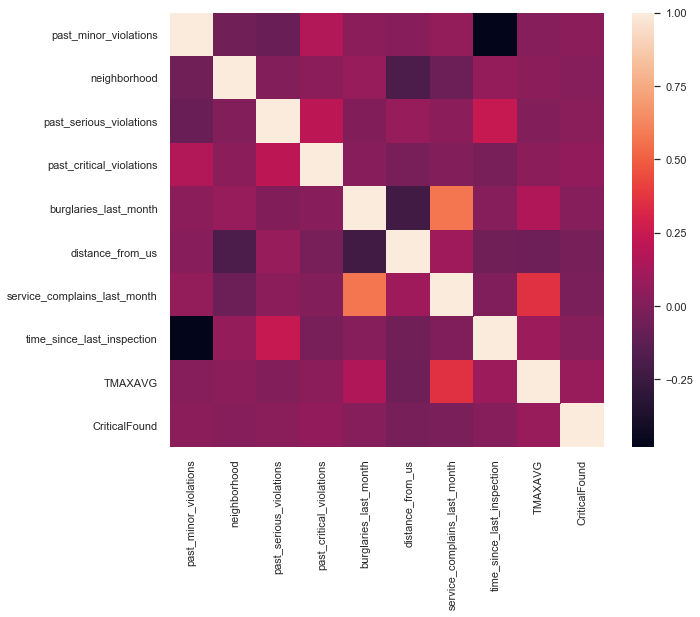

In [64]:
f, ax = plt.subplots(figsize=(10, 8))
corr = food_business_sample.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool),
            square=True, ax=ax)

plt.show()

In [ ]:
#Y_data = pd.DataFrame(data=Y_smote, columns = ['CriticalFound'])
#X_data.reset_index()
#Y_data.reset_index()
#Y_data = Y_data.values.reshape(-1,)
'''
X_train = pd.DataFrame(data=X_train, columns=features)
Y_train = pd.DataFrame(data=Y_train, columns = ['CriticalFound'])
X_test = pd.DataFrame(data=X_val, columns=features)
Y_test = pd.DataFrame(data=Y_val, columns = ['CriticalFound'])
X_train = X_train.reset_index()
Y_train = Y_train.reset_index()
X_val = X_val.reset_index()
Y_val = Y_val.reset_index()

X = food_business_train_sample[features]
Y = food_business_train_sample['CriticalFound']
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.3, random_state=103)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 5))
ax1.set_title('Before Scaling')
sns.distplot(X['service_complains_last_month'], ax=ax1)
sns.distplot(X['burglaries_last_month'], ax=ax1)
sns.distplot(X['past_serious_violations'], ax=ax1)
sns.distplot(X['past_critical_violations'], ax=ax1)
plt.show()

X['service_complains_last_month'] = (X['service_complains_last_month'] - X['service_complains_last_month'].mean())/X['service_complains_last_month'].std()
X['burglaries_last_month'] = (X['burglaries_last_month']-X['burglaries_last_month'].mean())/X['burglaries_last_month'].std()                                     
X['past_serious_violations'] = (X['past_serious_violations'] - X['past_serious_violations'].mean())/X['past_serious_violations'].std()
X['past_critical_violations'] = (X['past_critical_violations']-X['past_critical_violations'].mean())/X['past_critical_violations'].std()                                     
X['past_minor_violations'] = (X['past_minor_violations']-X['past_minor_violations'].mean())/X['past_minor_violations'].std()                                     

ax2.set_title('After Standard Scaler')
sns.distplot(X['service_complains_last_month'], ax=ax2)
#sns.distplot(X['burglaries_last_month'], ax=ax2)
#sns.distplot(X['past_serious_violations'], ax=ax2)
#sns.distplot(X['past_critical_violations'], ax=ax2)

'''

In [ ]:
print(X_train.shape)
print(Y_train.shape)
print(X_val.shape)
print(Y_val.shape)
#print(X_valid.shape)
#print(Y_valid.shape)

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 5))
ax1.set_title('Train Class Imbalance')
sns.countplot(x=Y_train, ax=ax1)
ax2.set_title('Test Class Imbalance')
sns.countplot(x=Y_val, ax=ax2)
plt.show()

We should note that there is class imbalance here and we should be careful about building our classfier. 

In [ ]:
#Make sure that there are no n/a values in our data frame.
print(X.isna().sum())

In [ ]:
from sklearn.manifold import TSNE

X_reduced_tsne = TSNE(n_components=2, random_state=42).fit_transform(X.values)
# t-SNE scatter plot
import matplotlib.patches as mpatches

f, ax = plt.subplots(figsize=(12, 12))

blue_patch = mpatches.Patch(color='#0A0AFF', label='No Critical')
red_patch = mpatches.Patch(color='#AF0000', label='Critical Found')

ax.scatter(X_reduced_tsne[:, 0],
           X_reduced_tsne[:, 1],
           c=(Y == 0),
           cmap='coolwarm',
           label='No Critical',
           linewidths=2)
ax.scatter(X_reduced_tsne[:, 0],
           X_reduced_tsne[:, 1],
           c=(Y == 1),
           cmap='coolwarm',
           label='Critical Found',
           linewidths=2)
ax.set_title('t-SNE', fontsize=18)

ax.grid(True)

ax.legend(handles=[blue_patch, red_patch])
plt.show()

In [ ]:
from sklearn.decomposition import PCA

X_reduced_pca = PCA(n_components=2, random_state=42).fit_transform(X.values)
# t-SNE scatter plot
import matplotlib.patches as mpatches

f, ax = plt.subplots(figsize=(12, 12))

blue_patch = mpatches.Patch(color='#0A0AFF', label='No Critical')
red_patch = mpatches.Patch(color='#AF0000', label='Critical Found')

ax.scatter(X_reduced_tsne[:, 0],
           X_reduced_pca[:, 1],
           c=(Y == 0),
           cmap='coolwarm',
           label='No Critical',
           linewidths=2)
ax.scatter(X_reduced_tsne[:, 0],
           X_reduced_pca[:, 1],
           c=(Y == 1),
           cmap='coolwarm',
           label='Critical Found',
           linewidths=2)
ax.set_title('PCA', fontsize=18)

ax.grid(True)

ax.legend(handles=[blue_patch, red_patch])
plt.show()

In [ ]:
def modelfit(alg,
             X_train,
             Y_train,
             performCV=True,
             printFeatureImportance=True,
             cv_folds=5):
    #Fit the algorithm on the data
    alg.fit(X_train, Y_train)

    #Predict training set:
    train_predictions = alg.predict(X_train)
    train_predprob = alg.predict_proba(X_train)[:, 1]

    #Perform cross-validation:
    if performCV:
        cv_score = cross_val_score(alg,
                                   X_train,
                                   Y_train,
                                   cv=cv_folds,
                                   scoring='roc_auc')

    #Print model report
    print("\nModel Report")
    print("Accuracy : %.4g" %
          metrics.accuracy_score(Y_train, train_predictions))
    print("AUC Score (Train): %f" %
          metrics.roc_auc_score(Y_train, train_predprob))

    if performCV:
        print("CV Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" %
              (np.mean(cv_score), np.std(cv_score), np.min(cv_score),
               np.max(cv_score)))

    #Print Feature Importance:
    if printFeatureImportance:
        importances = alg.feature_importances_
        indices = np.argsort(importances)[::-1]
        names = [features[i] for i in indices]
        feat_imp = pd.Series(alg.feature_importances_,
                             names).sort_values(ascending=False)
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')


def summarize_model_performance(trained_model, x_data, true_label):
    y_pred = trained_model.predict(x_data)
    y_pred_proba = trained_model.predict_proba(x_data)[:, 1]

    print("Accuracy = %s " % metrics.accuracy_score(true_label, y_pred))
    print("F1 Score = %s " % metrics.f1_score(true_label, y_pred))
    print("ROC-AUC Score = %s " %
          metrics.roc_auc_score(true_label, y_pred_proba))
    print("Recall-Score = %s " % metrics.recall_score(true_label, y_pred))
    print("Confusion Matrix\n")
    print(metrics.confusion_matrix(true_label, y_pred))
    print("Classification report")
    print(metrics.classification_report(true_label, y_pred))
    print("Log-Loss = %.3f" % metrics.log_loss(true_label, y_pred_proba))

    plot_roc_auc_curve(true_label, y_pred_proba)
    plot_precision_recall_curve(true_label, y_pred_proba)


def plot_roc_auc_curve(true_label, pred_label_proba):
    plt.figure(figsize=(8, 8))
    fpr, tpr, thresholds = metrics.roc_curve(true_label, pred_label_proba)
    plt.plot(fpr, tpr, label=' (area = %0.2f)'\
             % metrics.roc_auc_score(true_label, pred_label_proba))
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlim([-0.1, 1.0])
    plt.ylim([-0.1, 1.0])
    plt.rcParams['font.size'] = 12
    plt.title('ROC-AUC curve ')
    plt.xlabel('False Positive Rate (1 - Specificity)')
    plt.ylabel('True Positive Rate (Sensitivity)')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()


def plot_precision_recall_curve(true_label, pred_label_proba):
    plt.figure(figsize=(8, 8))
    precision, recall, thresholds = metrics.precision_recall_curve(
        true_label, pred_label_proba)
    plt.plot(recall, precision, marker='.')
    plt.plot([0, 1], [0.1, 0.1], linestyle='--')
    plt.xlim([-0.1, 1.0])
    plt.ylim([-0.1, 1.0])
    plt.rcParams['font.size'] = 12
    plt.title('Precision-Recall Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.grid(True)
    plt.show()

### Logistic Regression Model 

In [ ]:
# train a logistic regression model on the training set
# instantiate model
logreg = LogisticRegression(random_state=101)
print(logreg)

logreg.fit(X_train, Y_train)
summarize_model_performance(logreg, X_val, Y_val)

In [ ]:
param_grid = {
    'C': [0.5, 1, 1.5, 2.0, 2.5, 3.0, 4, 5],
    'class_weight': [None, "balanced"],
    'max_iter': [10, 20, 50, 100, 110, 120, 150, 200, 500, 700, 1000]
}
lgr_rand_search = RandomizedSearchCV(estimator=logreg,
                                     param_distributions=param_grid,
                                     n_iter=100,
                                     cv=5,
                                     n_jobs=-1,
                                     random_state=101)

lgr_rand_search.fit(X_train, Y_train)
#Best estimator and CV score
print('Best Accuracy score ', lgr_rand_search.best_score_)
print(lgr_rand_search.best_estimator_)

logreg = lgr_rand_search.best_estimator_

In [ ]:
# fit model
modelfit(logreg, X_train, Y_train, True, False, 5)
print("Logistic regression coefficients \n")
print(logreg.coef_)

In [ ]:
summarize_model_performance(logreg, X_val, Y_val)

In [ ]:
X_test = food_business_test_sample[features]
Y_test = food_business_test_sample['CriticalFound']
print('Test Summary ')
summarize_model_performance(logreg, X_test, Y_test)

## DecisionTree Classifier

In [ ]:
dt = DecisionTreeClassifier(random_state=101,
                            class_weight='balanced',
                            criterion='entropy')
print(dt)

modelfit(dt, X_train, Y_train, True, True, 5)

param_grid = {
    'max_leaf_nodes': [5, 10, 15, 20, 25, 30, 35, 50],
    'min_samples_split': [2, 2, 4, 6, 8],
    'max_depth': [1, 5, 10, 15, 20],
    'min_samples_leaf': [1, 2, 5, 10, 15, 20]
}
dt_rand_search = RandomizedSearchCV(estimator=dt,
                                    param_distributions=param_grid,
                                    cv=5,
                                    n_iter=100,
                                    n_jobs=-1,
                                    random_state=101)

dt_rand_search.fit(X_train, Y_train)

#Best estimator and CV score
print(dt_rand_search.best_estimator_)

dt = dt_rand_search.best_estimator_

In [ ]:
summarize_model_performance(dt, X_val, Y_val)

In [ ]:
summarize_model_performance(dt, X_test, Y_test)

## Random Forest

In [ ]:
rf = RandomForestClassifier(random_state=101, n_jobs=-1)
print(rf)

In [ ]:
n_estimators = [int(x) for x in np.linspace(start=1, stop=500, num=25)]
param_grid_RF = {
    'n_estimators': n_estimators,
    'max_features': np.arange(1, len(features)),
    'min_samples_split': [2, 4, 6, 8],
    'max_depth': [1, 5, 10, 15, 20, 30, 50],
    'min_samples_leaf': [1, 2, 5, 10, 15, 20],
    'bootstrap': [True, False]
}
rf_rand_search = RandomizedSearchCV(estimator=rf,
                                    param_distributions=param_grid_RF,
                                    n_iter=100,
                                    cv=5,
                                    random_state=101)
rf_rand_search.fit(X_train, Y_train)
print(rf_rand_search.best_estimator_)
clf = rf_rand_search.best_estimator_
modelfit(clf, X_train, Y_train, True, True, 5)

In [ ]:
summarize_model_performance(clf, X_val, Y_val)

In [ ]:
predictors = features
gbm0 = GradientBoostingClassifier(random_state=10)
print(gbm0)

In [ ]:
modelfit(gbm0, X_train, Y_train)

In [ ]:
summarize_model_performance(gbm0, X_val, Y_val)

In [ ]:
n_features = np.arange(1, len(features))
print(n_features)
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 1],
    'n_estimators': [100, 150, 200, 500],
    'max_features': n_features
}
#gbm_model_tuned = GradientBoostingClassifier(random_state=10)
gbm_grid_search = RandomizedSearchCV(estimator=gbm0,
                                     param_distributions=param_grid,
                                     cv=10,
                                     random_state=10,
                                     n_jobs=-1)

gbm_grid_search.fit(X_train, Y_train)

print('Best Accuracy score ', gbm_grid_search.best_score_)
print(gbm_grid_search.best_estimator_)

gbm_final = gbm_grid_search.best_estimator_

In [ ]:
summarize_model_performance(gbm_final, X_val, Y_val)

In [ ]:
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 1],
    'eval_metric': ['auc'],
    'gamma': [0.5, 1, 1.5, 2, 5],
    'max_depth': [2, 4, 6, 8, 10, 12, 14, 18, 20, 25],
    'n_estimators': [100, 200, 300, 500, 1000],
    'scale_pos_weight': [1, 2, 3, 4, 5]
}
xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=101)
xgb_grid_search = RandomizedSearchCV(estimator=xgb_model,
                                     param_distributions=param_grid,
                                     cv=5,
                                     random_state=101,
                                     n_jobs=-1)
X_train = pd.DataFrame(data=X_train, columns=features)
X_val = pd.DataFrame(data=X_val, columns=features)
xgb_grid_search.fit(X_train, Y_train)
#Best estimator and CV score
print('Best Accuracy score ', xgb_grid_search.best_score_)
print(xgb_grid_search.best_estimator_)

xgb_model = xgb_grid_search.best_estimator_
print('Validation Summary ')
summarize_model_performance(xgb_model, X_val, Y_val)

In [ ]:
xgb_model.get_booster().feature_names

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
class_weight = {0: 1.,
                1: 5.}
model = Sequential()
model.add(Dense(16, input_dim=8, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
# compile the keras model
optimizer = Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# fit the keras model on the dataset
model.fit(X_train, Y_train, epochs=500, batch_size=100, class_weight=class_weight)
# evaluate the keras model
_, accuracy = model.evaluate(X_test, Y_test)
print('Accuracy: %.2f' % (accuracy*100))
